Import required libraries


In [103]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [104]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report


Download Required NLTK Resources

In [105]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load the BBC News Dataset

In [106]:
data = []
labels = []

dataset_path = os.getcwd()
categories = ["business", "entertainment", "politics", "sport", "tech"]

for category in categories:
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        with open(os.path.join(category_path, file), "r", encoding="latin-1") as f:
            data.append(f.read())
            labels.append(category)

df = pd.DataFrame({
    "text": data,
    "label": labels
})






In [107]:
print("Total Articles:", len(df))
df.head()

Total Articles: 2225


,text,label
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [108]:
print(df["label"].value_counts())


label
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


Data Cleaning

In [109]:
df=df.drop_duplicates(keep='first')

In [110]:
df.shape

(2127, 2)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2127 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2127 non-null   object
 1   label   2127 non-null   object
dtypes: object(2)
memory usage: 49.9+ KB


In [112]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [113]:
df.head()

,text,label
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


EDA

In [114]:
df.label.value_counts()

label
sport            505
business         503
politics         403
entertainment    369
tech             347
Name: count, dtype: int64

<Axes: ylabel='label'>

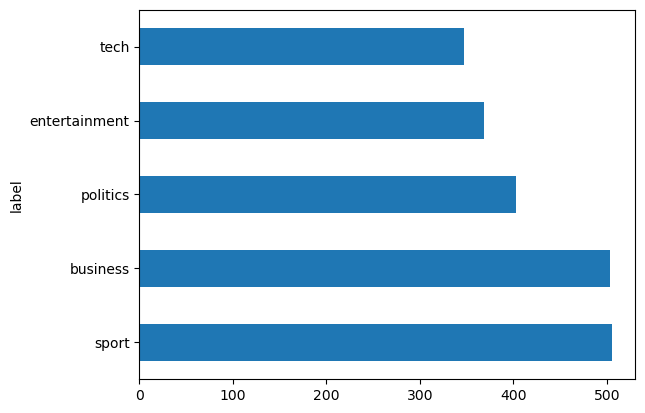

In [115]:
df.label.value_counts().plot.barh()

In [116]:
df['num_char']=df['text'].apply(len)
df['num_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sent']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [117]:
df.head()

,text,label,num_char,num_words,num_sent
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,2560,490,20
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,2252,433,15
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,1552,294,12
3,High fuel prices hit BA's profits\n\nBritish A...,business,2412,472,19
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,1570,306,12


  Text Preprocessing

In [118]:
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word.isalpha() and word not in stop_words
    ]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(preprocess_text)




In [119]:
df.head()

,text,label,num_char,num_words,num_sent,clean_text
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,2560,490,20,ad sale boost time warner profit quarterly pro...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,2252,433,15,dollar gain greenspan speech dollar hit highes...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,1552,294,12,yukos unit buyer face loan claim owner embattl...
3,High fuel prices hit BA's profits\n\nBritish A...,business,2412,472,19,high fuel price hit ba profit british airway b...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,1570,306,12,pernod takeover talk lift domecq share uk drin...


Feature Extraction using TF-IDF

In [120]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["clean_text"])
y = df["label"]

In [121]:
print("TF-IDF Feature Matrix Shape:", X.shape)

TF-IDF Feature Matrix Shape: (2127, 5000)


Train-Test Split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training Samples:", X_train.shape[0])
print("Testing Samples:", X_test.shape[0])

Training Samples: 1701
Testing Samples: 426


Train Models

In [123]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


MultinomialNB()

In [124]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [125]:
# Support Vector Machine
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

LinearSVC()

Evaluation

In [126]:
print("\n Accuracy Comparison ")
print("Naive Bayes          :", accuracy_score(y_test, nb_pred))
print("Logistic Regression :", accuracy_score(y_test, lr_pred))
print("SVM                 :", accuracy_score(y_test, svm_pred))

print("\n Classification Report (Logistic Regression) ")
print(classification_report(y_test, lr_pred))


 Accuracy Comparison 
Naive Bayes          : 0.9812206572769953
Logistic Regression : 0.9906103286384976
SVM                 : 0.9788732394366197

 Classification Report (Logistic Regression) 
               precision    recall  f1-score   support

     business       1.00      0.98      0.99       101
entertainment       0.99      1.00      0.99        74
     politics       0.99      0.99      0.99        81
        sport       1.00      1.00      1.00       101
         tech       0.97      0.99      0.98        69

     accuracy                           0.99       426
    macro avg       0.99      0.99      0.99       426
 weighted avg       0.99      0.99      0.99       426



Predict

In [127]:
def predict_news_category(text, model, vectorizer):
    clean_text = preprocess_text(text)
    vector = vectorizer.transform([clean_text])
    return model.predict(vector)[0]


In [128]:
sample_news = """
The government announced new economic reforms to boost
business growth and foreign investment.
"""

print("Sample News:")
print(sample_news.strip())
print("-" * 50)

print("Naive Bayes Prediction        :", predict_news_category(sample_news, nb_model, tfidf))
print("Logistic Regression Prediction:", predict_news_category(sample_news, lr_model, tfidf))
print("SVM Prediction               :", predict_news_category(sample_news, svm_model, tfidf))



Sample News:
The government announced new economic reforms to boost
business growth and foreign investment.
--------------------------------------------------
Naive Bayes Prediction        : business
Logistic Regression Prediction: business
SVM Prediction               : business


Confusion MMatrix

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


<Figure size 600x600 with 0 Axes>

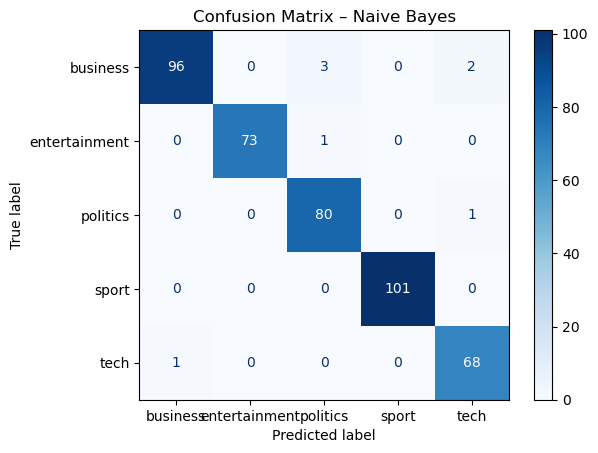

In [130]:
#Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, nb_pred)

disp_nb = ConfusionMatrixDisplay(
    confusion_matrix=cm_nb,
    display_labels=nb_model.classes_
)

plt.figure(figsize=(6, 6))
disp_nb.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Naive Bayes")
plt.show()


<Figure size 600x600 with 0 Axes>

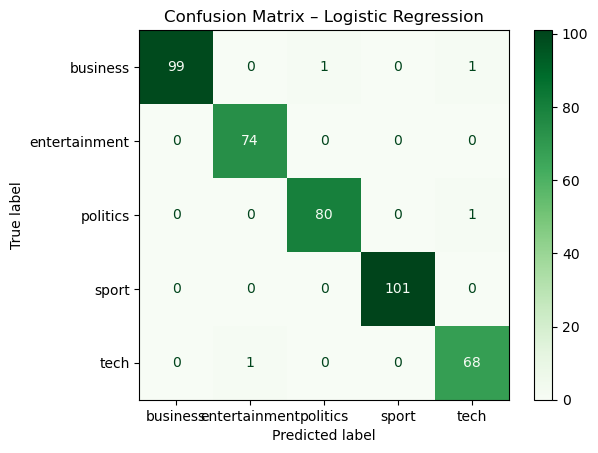

In [131]:
#Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, lr_pred)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=lr_model.classes_
)

plt.figure(figsize=(6, 6))
disp_lr.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


<Figure size 600x600 with 0 Axes>

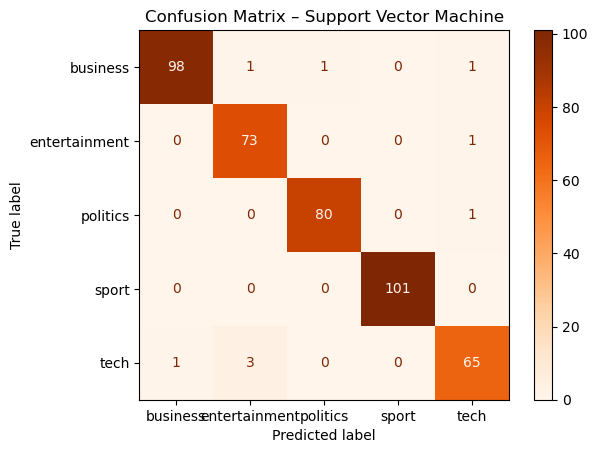

In [132]:
#Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, svm_pred)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm_model.classes_
)

plt.figure(figsize=(6, 6))
disp_svm.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix – Support Vector Machine")
plt.show()
